# Nouvelle section

importation et preparation des donnée:

la dataset SANAD_SUBJECT contenant 3 dataset respectivement dupliquer entr train et test data


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilisation de l'appareil : {device}")

dataset_dir = "/kaggle/input/sanad-subset"
sources = ["akhbarona"]

def load_data(data_dir, sources):
    data = []
    for source in sources:
        source_path = os.path.join(data_dir, source)
        for split in ["Train", "Test"]:
            split_path = os.path.join(source_path, split)
            if not os.path.exists(split_path):
                print(f"Split folder '{split}' not found in {source_path}. Skipping.")
                continue

            for category in os.listdir(split_path):
                category_path = os.path.join(split_path, category)
                if os.path.isdir(category_path):
                    for file in os.listdir(category_path):
                        file_path = os.path.join(category_path, file)
                        if os.path.isfile(file_path):
                            try:
                                with open(file_path, 'r', encoding='utf-8') as f:
                                    text = f.read().strip()
                                    data.append({"text": text, "label": category})
                            except Exception as e:
                                print(f"Error reading file {file_path}: {e}")
    return data

print("Chargement des données...")
all_data = load_data(dataset_dir, sources)

if len(all_data) == 0:
    raise ValueError("No data was loaded. Check your dataset structure.")

df = pd.DataFrame(all_data)
print(f"Nombre total de données : {len(df)}")

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print("Aperçu des données d'entraînement :")
print(train_df.head())
print(f"Nombre de données d'entraînement : {len(train_df)}")
print(f"Nombre de données de test : {len(test_df)}")

Utilisation de l'appareil : cuda
Chargement des données...
Nombre total de données : 46900
Aperçu des données d'entraînement :
                                                    text     label
4647   Title\nمراكش ..الدعوة إلى ضرورة تأهيل وتثمين ق...   Finance
16917  Title\n«شؤون القصّر» تطالب المنظمات الإسلامية ...  Religion
16315  Title\nعلامات الساعه الصغرى\n\nBody\nأهم علاما...  Religion
2457   Title\nافتتاح مشروع طريق آسفي السيار في خبر كا...   Finance
3125   Title\nتفاصيل ما تريد المعارضة تعديله في مشروع...   Finance
Nombre de données d'entraînement : 42210
Nombre de données de test : 4690


In [ ]:
categories = train_df["label"].unique()
label_mapping = {label: idx for idx, label in enumerate(categories)}

train_df["label"] = train_df["label"].map(label_mapping)
test_df["label"] = test_df["label"].map(label_mapping)

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

print(f"Nombre de textes d'entraînement : {len(train_texts)}")
print(f"Nombre de textes de validation : {len(val_texts)}")
print(f"Nombre de textes de test : {len(test_texts)}")

Nombre de textes d'entraînement : 37989
Nombre de textes de validation : 4221
Nombre de textes de test : 4690


2-Tokenisation avecle tokeniseur araBert:

On utilise le tokenizer de BERT pour convertir les textes en tokens exploitables par le modèle.

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import pandas as pd
from datasets import Dataset

MODEL_NAME = "aubmindlab/bert-base-arabertv2"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def subsample_dataset(dataset, sample_size):
    """Randomly sample a subset of the dataset."""
    return dataset.sample(n=sample_size, random_state=42)

TRAIN_SAMPLE_SIZE = 37989
VALID_SAMPLE_SIZE = 4221
TEST_SAMPLE_SIZE = 4690

train_df_small = subsample_dataset(train_df, TRAIN_SAMPLE_SIZE)
val_df_small = subsample_dataset(test_df, VALID_SAMPLE_SIZE)
test_df_small = subsample_dataset(test_df, TEST_SAMPLE_SIZE)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

train_dataset = Dataset.from_pandas(train_df_small).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df_small).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df_small).map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/37989 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/4690 [00:00<?, ? examples/s]

**3-Fine-Tuning du Modèle araBERT :**

On entraîne un modèle araBert pour la classification de texte.

**Entrainement du model AraBert:**

In [ ]:
pip install wandb

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import wandb
wandb.login(key="934b841ba03cd8e2eeb66392d00f42a960cf28b1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: douireky1 (douireky1-no-company). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
pip install bert-score

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


**Changing Hyperparameters**

We noticed there might be some **Overfitting** in our first training result so we decided to change some hyperparameters :
weight decay : 0.01 ---> 0.1
learning rate : 2e-5 ---> 1e-5
batch size : 16 ---> 8
we also implemented **Early Stopping**

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(categories))
model.to("cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

training_args = TrainingArguments(
    output_dir="./bert_standard_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)
trainer.train()
model.save_pretrained("./bert_standard_model")
tokenizer.save_pretrained("./bert_standard_model")
print("Modèle BERT standard entraîné et sauvegardé.")

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.110500,0.211457,0.948353
2,0.222900,0.216148,0.948117
3,0.160100,0.259431,0.949301
4,0.238400,0.243500,0.955461
5,0.017100,0.259312,0.954039


Modèle BERT standard entraîné et sauvegardé.


In [ ]:
from bert_score import score

ground_truths = ["النص الحقيقي ١", "النص الحقيقي ٢", "النص الحقيقي ٣"]
predictions = ["النص المتوقع ١", "النص المتوقع ٢", "النص المتوقع ٣"]

P, R, F1 = score(predictions, ground_truths, lang="ar")
print(f"BERTScore Precision: {P.mean().item()}")
print(f"BERTScore Recall: {R.mean().item()}")
print(f"BERTScore F1: {F1.mean().item()}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore Precision: 0.8417925834655762
BERTScore Recall: 0.8908848166465759
BERTScore F1: 0.8656415343284607


**Implémentation de l’Attention Différentielle**

In [ ]:
import torch
import torch.nn as nn
import math

class DifferentialMultiHeadAttention(nn.Module):
    """
    A custom multi-head attention module implementing your 'differential' mechanism.
    This skeleton demonstrates how you might plug into an existing Transformer stack.
    """

    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob=0.1):
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({hidden_size}) is not a multiple of the number of attention heads ({num_attention_heads})"
            )
        self.num_attention_heads = num_attention_heads
        self.head_dim = hidden_size // num_attention_heads

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)
        self.out_proj = nn.Linear(hidden_size, hidden_size)

        self.differential_param = nn.Parameter(torch.ones(self.num_attention_heads))

    def transpose_for_scores(self, x):
        """
        Reshape the input tensor so we can handle multiple heads in parallel.
        """
        new_shape = x.size()[:-1] + (self.num_attention_heads, self.head_dim)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        """
        hidden_states: (batch_size, seq_len, hidden_size)
        attention_mask: (batch_size, 1, 1, seq_len) or similar shape with 0 / -inf for masking
        """
        # 1) Project to query, key, value
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer   = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        # 2) Compute raw attention scores
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.head_dim)

        # 3) Apply attention mask (e.g., padding or causal mask)
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # 4) Convert to probabilities with softmax
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # 5) Apply custom differential logic
        attention_probs = attention_probs * self.differential_param.view(1, -1, 1, 1)

        # 6) Dropout on attention probs
        attention_probs = self.dropout(attention_probs)

        # 7) Compute context
        context_layer = torch.matmul(attention_probs, value_layer)

        # 8) Reshape back
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_shape = context_layer.size()[:-2] + (self.num_attention_heads * self.head_dim,)
        context_layer = context_layer.view(*new_context_shape)

        # 9) Output projection
        attention_output = self.out_proj(context_layer)

        return attention_output


In [ ]:
import random
from transformers import BertForSequenceClassification, BertConfig

def replace_bert_attention_layers(model, fraction=0.25):
    """
    Replace a fraction of BERT's self-attention modules with the custom DifferentialMultiHeadAttention.
    fraction: float (0.25 means 25% of the layers)
    """

    # The BERT encoder layers
    layers = model.bert.encoder.layer
    num_layers = len(layers)
    num_replace = int(num_layers * fraction)

    # Randomly pick which layers to replace
    indices_to_replace = random.sample(range(num_layers), num_replace)

    for idx in indices_to_replace:
        bert_self_attention = layers[idx].attention.self  # The original self-attention

        hidden_size = bert_self_attention.all_head_size
        num_heads = bert_self_attention.num_attention_heads
        dropout_prob = bert_self_attention.dropout.p if bert_self_attention.dropout is not None else 0.1

        # Create an instance of our differential attention
        diff_attention = DifferentialMultiHeadAttention(
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            attention_probs_dropout_prob=dropout_prob
        )

        # Replace the original self-attention module
        layers[idx].attention.self = diff_attention

    print(f"Replaced {num_replace} out of {num_layers} layers with DifferentialMultiHeadAttention.")


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bert_differential_attention_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,  # <-- Our partially replaced model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,   # compute_metrics function
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.001500,0.268057,0.954513
2,0.050000,0.307663,0.949775
3,0.000300,0.325085,0.951907


TrainOutput(global_step=14247, training_loss=0.051088580615537935, metrics={'train_runtime': 1835.8145, 'train_samples_per_second': 62.08, 'train_steps_per_second': 7.761, 'total_flos': 7496830951545600.0, 'train_loss': 0.051088580615537935, 'epoch': 3.0})

In [ ]:
test_metrics = trainer.evaluate(test_dataset)
print("Test Metrics with partial differential attention:", test_metrics)

Test Metrics with partial differential attention: {'eval_loss': 0.2659779489040375, 'eval_accuracy': 0.9552238805970149, 'eval_runtime': 19.1138, 'eval_samples_per_second': 245.372, 'eval_steps_per_second': 30.711, 'epoch': 3.0}


In [ ]:
from bert_score import score

# Example for BERTScore on some textual predictions vs. references
predictions = ["النص المتوقع ١", "النص المتوقع ٢", "النص المتوقع ٣"]
references  = ["النص الحقيقي ١", "النص الحقيقي ٢", "النص الحقيقي ٣"]

P, R, F1 = score(predictions, references, lang="ar")
print(f"BERTScore (P, R, F1): {P.mean().item()}, {R.mean().item()}, {F1.mean().item()}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERTScore (P, R, F1): 0.8417925834655762, 0.8908848166465759, 0.8656415343284607


In [ ]:
save_directory = "./bert_differential_attention_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./bert_differential_attention_model


In [ ]:
from bert_score import score

predictions = [
    "الثقافة تعد من الركائز الأساسية التي تعبر عن هوية الشعوب وتميزها. فهي تشمل الأدب، والفن، والعادات، والتقاليد التي تنتقل عبر الأجيال...",
    "الدين يعد جزءًا أساسيًا من حياة الكثير من الناس، حيث يشكل مصدرًا للإلهام والقيم الأخلاقية...",
    "قطاع المال والاستثمار يشكل عصب الاقتصاد في العالم الحديث، حيث تلعب الأسواق المالية دورًا رئيسيًا...",
    "السياسة تُعتبر العامل المحوري الذي يحدد شكل العلاقات بين الدول ويؤثر على استقرار الشعوب...",
    "التكنولوجيا أصبحت العمود الفقري للتقدم في العصر الحديث، حيث تلعب دورًا حاسمًا في تحسين جودة الحياة...",
    "الرياضة ليست مجرد منافسة، بل هي وسيلة لتعزيز الصحة والتواصل بين الشعوب..."
]
references = [
    "الثقافة هي أساس الهوية الوطنية وتنعكس في الأدب والفن والعادات. من خلال الثقافات يتم بناء جسور التفاهم بين الشعوب...",
    "الدين يمثل جزءًا هامًا من القيم الأخلاقية، ويشكل إطارًا للسلام والتعايش بين الناس من مختلف الخلفيات...",
    "الاستثمار والأسواق المالية تعد حجر الزاوية لاقتصاد مستدام وتنمية مستمرة، خاصة مع التركيز على الابتكار المالي...",
    "السياسة تحدد استراتيجيات الدول وتحكم العلاقات الإقليمية والدولية مع تأثير مباشر على الأمن والتنمية...",
    "التكنولوجيا تسهم في تحسين حياة البشر بفضل الذكاء الاصطناعي والابتكارات التي تسهل الحياة اليومية...",
    "الرياضة تجمع الشعوب وتساهم في بناء صحة الأفراد، مع أهمية خاصة للأحداث الدولية التي تعزز الوحدة العالمية..."
]
# BERTScore
P, R, F1 = score(predictions, references, lang="ar")

print(f"BERTScore Precision: {P.mean().item()}")
print(f"BERTScore Recall: {R.mean().item()}")
print(f"BERTScore F1: {F1.mean().item()}")

BERTScore Precision: 0.7892808318138123
BERTScore Recall: 0.7831194996833801
BERTScore F1: 0.7860890030860901


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned model and tokenizer
save_directory = "./bert_differential_attention_model"
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)

print("Model and tokenizer successfully loaded!")

Model and tokenizer successfully loaded!


In [ ]:
import torch
from transformers import pipeline

# Test data
test_texts = [
    "اللهم لا تجعلنا مقبلين على ما يضرنا.",
    "الحج هو أحد أركان الإسلام الخمسة.",
    "القرآن الكريم يُعتبر دستور حياة المسلمين.",
    "الصلاة تعزز العلاقة بين العبد وربه.",
    "أسعار الأسهم ترتفع بشكل كبير."
    "التضخم يواصل الارتفاع ويؤثر على أسعار السلع.",
    "البنك المركزي يقرر رفع سعر الفائدة.",
    "سوق الأسهم يشهد تراجعًا بسبب تقلبات الاقتصاد العالمي.",
    "آبل تطلق هاتفًا جديدًا مزودًا بتقنيات متقدمة.",
    "منتخب السعودية يحقق فوزًا مثيرًا في تصفيات كأس العالم.",
    "رونالدو يُسجل هدفًا تاريخيًا في دوري الأبطال.",
    "بطولة التنس العالمية تنطلق في دبي بمشاركة نخبة اللاعبين.",
    "قرار جديد يهدف إلى تعزيز العلاقات الدبلوماسية بين الدول.",
    "المهرجان الثقافي يُبرز التنوع الفني والتراثي للمنطقة.",
    "اللغة العربية هي جسر للتواصل الثقافي والحضاري.",
    "الروايات الأدبية تُعتبر مرآة تعكس واقع المجتمعات."

]
test_encodings = loaded_tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Move tensors to the same device as the model
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

# Get predictions
with torch.no_grad():
    outputs = loaded_model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Map numeric predictions back to labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [inverse_label_mapping[pred.item()] for pred in predictions]

# Print results
for text, label in zip(test_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: اللهم لا تجعلنا مقبلين على ما يضرنا.
Predicted Label: Religion

Text: الحج هو أحد أركان الإسلام الخمسة.
Predicted Label: Religion

Text: القرآن الكريم يُعتبر دستور حياة المسلمين.
Predicted Label: Religion

Text: الصلاة تعزز العلاقة بين العبد وربه.
Predicted Label: Religion

Text: أسعار الأسهم ترتفع بشكل كبير.التضخم يواصل الارتفاع ويؤثر على أسعار السلع.
Predicted Label: Finance

Text: البنك المركزي يقرر رفع سعر الفائدة.
Predicted Label: Finance

Text: سوق الأسهم يشهد تراجعًا بسبب تقلبات الاقتصاد العالمي.
Predicted Label: Finance

Text: آبل تطلق هاتفًا جديدًا مزودًا بتقنيات متقدمة.
Predicted Label: Tech

Text: منتخب السعودية يحقق فوزًا مثيرًا في تصفيات كأس العالم.
Predicted Label: Sports

Text: رونالدو يُسجل هدفًا تاريخيًا في دوري الأبطال.
Predicted Label: Sports

Text: بطولة التنس العالمية تنطلق في دبي بمشاركة نخبة اللاعبين.
Predicted Label: Sports

Text: قرار جديد يهدف إلى تعزيز العلاقات الدبلوماسية بين الدول.
Predicted Label: Politics

Text: المهرجان الثقافي يُبرز التنوع الفني و

Both models loaded successfully.


Map:   0%|          | 0/4690 [00:00<?, ? examples/s]

Map:   0%|          | 0/4690 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4690
})
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4690
})


Standard BERT Results: {'eval_loss': 0.24578334391117096, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.9550106609808102, 'eval_runtime': 19.1342, 'eval_samples_per_second': 245.11, 'eval_steps_per_second': 30.678}


Differential BERT Results: {'eval_loss': 0.2659779489040375, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.9552238805970149, 'eval_runtime': 19.0818, 'eval_samples_per_second': 245.784, 'eval_steps_per_second': 30.762}
Comparison of Results:
Accuracy (Standard BERT): 0.9550106609808102
Accuracy (Differential BERT): 0.9552238805970149


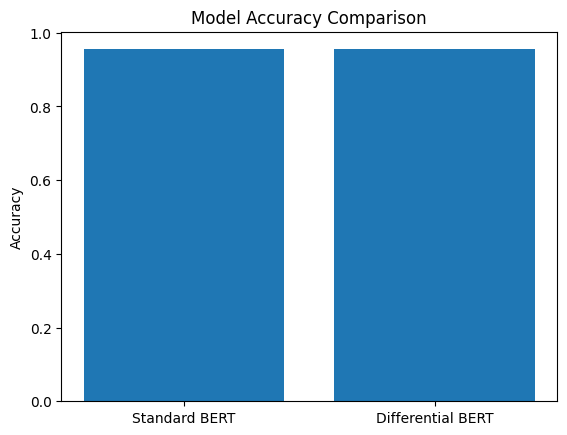

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import Dataset

# Paths to the saved models
standard_model_path = "./bert_standard_model"
differential_model_path = "./bert_differential_attention_model"

# Load standard BERT model and tokenizer
standard_model = BertForSequenceClassification.from_pretrained(standard_model_path)
standard_tokenizer = BertTokenizer.from_pretrained(standard_model_path)

# Load differential BERT model and tokenizer
differential_model = BertForSequenceClassification.from_pretrained(differential_model_path)
differential_tokenizer = BertTokenizer.from_pretrained(differential_model_path)

print("Both models loaded successfully.")

# Define the tokenize_function
def tokenize_function(examples):
    return standard_tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

# Tokenize test dataset for standard model
test_dataset_standard = Dataset.from_pandas(test_df).map(
    tokenize_function, batched=True
)

# Rename label column and set format
test_dataset_standard = test_dataset_standard.rename_column("label", "labels")
test_dataset_standard.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Tokenize test dataset for differential BERT model
test_dataset_differential = Dataset.from_pandas(test_df).map(
    lambda x: differential_tokenizer(
        x["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    ),
    batched=True
)

# Rename label column and set format
test_dataset_differential = test_dataset_differential.rename_column("label", "labels")
test_dataset_differential.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Verify dataset structure
print(test_dataset_differential)


# Print to verify
print(test_dataset_standard)

from transformers import Trainer

# Define compute_metrics function (e.g., accuracy)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Evaluate standard BERT
trainer_standard = Trainer(
    model=standard_model,
    eval_dataset=test_dataset_standard,
    tokenizer=standard_tokenizer,
    compute_metrics=compute_metrics,
)
results_standard = trainer_standard.evaluate()
print(f"Standard BERT Results: {results_standard}")

# Evaluate differential BERT
trainer_differential = Trainer(
    model=differential_model,
    eval_dataset=test_dataset_differential,
    tokenizer=differential_tokenizer,
    compute_metrics=compute_metrics,
)
results_differential = trainer_differential.evaluate()
print(f"Differential BERT Results: {results_differential}")

print("Comparison of Results:")
print(f"Accuracy (Standard BERT): {results_standard['eval_accuracy']}")
print(f"Accuracy (Differential BERT): {results_differential['eval_accuracy']}")

import matplotlib.pyplot as plt

# Data for comparison
models = ["Standard BERT", "Differential BERT"]
accuracies = [
    results_standard["eval_accuracy"],
    results_differential["eval_accuracy"],
]

# Plot
plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Tokenize the test dataset for the standard model
test_dataset_standard = Dataset.from_pandas(test_df).map(
    lambda x: standard_tokenizer(
        x["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    ),
    batched=True
)
test_dataset_standard = test_dataset_standard.rename_column("label", "labels")
test_dataset_standard.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Tokenize the test dataset for the differential model
test_dataset_differential = Dataset.from_pandas(test_df).map(
    lambda x: differential_tokenizer(
        x["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    ),
    batched=True
)
test_dataset_differential = test_dataset_differential.rename_column("label", "labels")
test_dataset_differential.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Evaluate standard model
trainer_standard = Trainer(
    model=standard_model,
    eval_dataset=test_dataset_standard,
    tokenizer=standard_tokenizer,
    compute_metrics=compute_metrics,
)
results_standard = trainer_standard.evaluate()
print(f"Standard BERT Results: {results_standard}")

# Evaluate differential model
trainer_differential = Trainer(
    model=differential_model,
    eval_dataset=test_dataset_differential,
    tokenizer=differential_tokenizer,
    compute_metrics=compute_metrics,
)
results_differential = trainer_differential.evaluate()
print(f"Differential BERT Results: {results_differential}")

Map:   0%|          | 0/4690 [00:00<?, ? examples/s]

Map:   0%|          | 0/4690 [00:00<?, ? examples/s]

Standard BERT Results: {'eval_loss': 0.24578334391117096, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': 0.9550106609808102, 'eval_runtime': 18.9692, 'eval_samples_per_second': 247.242, 'eval_steps_per_second': 30.945}


Differential BERT Results: {'eval_loss': 0.2659779489040375, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': 0.9552238805970149, 'eval_runtime': 18.9002, 'eval_samples_per_second': 248.146, 'eval_steps_per_second': 31.058}


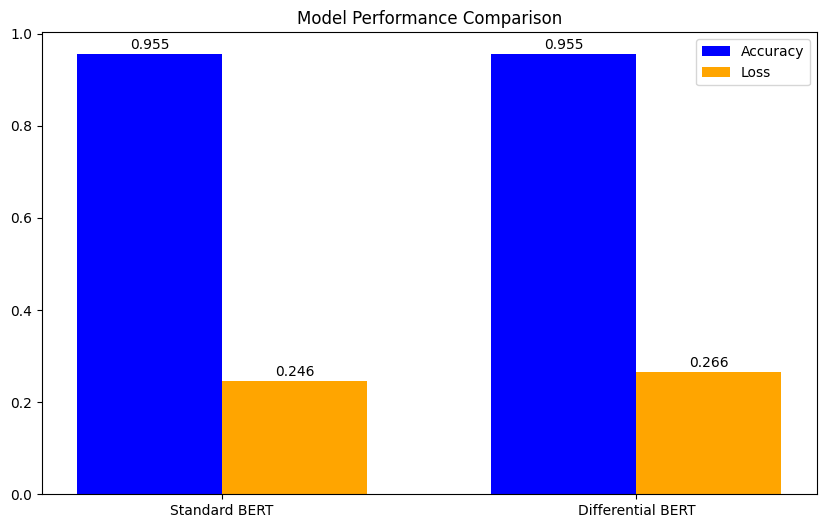

In [ ]:
import numpy as np

# Extract values for plotting
models = ["Standard BERT", "Differential BERT"]
losses = [results_standard['eval_loss'], results_differential['eval_loss']]
accuracies = [results_standard['eval_accuracy'], results_differential['eval_accuracy']]


# Data for combined graph
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy bars
bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='blue')
# Loss bars
bars2 = ax1.bar(x + width/2, losses, width, label='Loss', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

# Add values on top of bars
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{bar.get_height():.3f}", ha='center', va='bottom')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{bar.get_height():.3f}", ha='center', va='bottom')

plt.show()
